# Chess ELO Rating ML Prediction Project

This project aims to predict both White and Black player ELO ratings from chess game data using ML techniques. Namely through Linear Regression, and tree-based approaches such as Random Forests, and XGBoost.

### Imports

In [44]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE


## Data Loading and Setup

In [45]:
# Load the data - this is a filtered down version that only includes rapid games from the full dataset in https://www.kaggle.com/datasets/shkarupylomaxim/chess-games-dataset-lichess-2017-may/data dataset.
df = pd.read_csv('./data/rapid_only_games_metadata_profile_2024_01.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.info()
df.head().T

Dataset shape: (37670, 21)

Columns: ['Date', 'WhiteElo', 'White_tosViolation', 'White_profile_flag', 'White_createdAt', 'White_playTime_total', 'White_count_all', 'White_title', 'BlackElo', 'Black_tosViolation', 'Black_profile_flag', 'Black_createdAt', 'Black_playTime_total', 'Black_count_all', 'Black_title', 'Moves', 'TotalMoves', 'ECO', 'Opening', 'Termination', 'Result']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37670 entries, 0 to 37669
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  37670 non-null  object 
 1   WhiteElo              37670 non-null  int64  
 2   White_tosViolation    952 non-null    object 
 3   White_profile_flag    9938 non-null   object 
 4   White_createdAt       36930 non-null  float64
 5   White_playTime_total  36893 non-null  float64
 6   White_count_all       36930 non-null  float64
 7   White_title           87 non-null     object 
 8 

,0,1,2,3,4
Date,2024.01.01,2024.01.01,2024.01.01,2024.01.01,2024.01.01
WhiteElo,2289,1205,1072,1661,1660
White_tosViolation,NaN,NaN,NaN,NaN,NaN
White_profile_flag,NaN,NaN,NaN,NaN,_united-nations
White_createdAt,1694283583237.0,1628263032606.0,1663178334974.0,1680980511140.0,1543439485792.0
White_playTime_total,1154156.0,886600.0,1959945.0,523520.0,7372367.0
White_count_all,2352.0,1684.0,2314.0,1015.0,13436.0
White_title,NaN,NaN,NaN,NaN,NaN
BlackElo,2307,1214,1131,1638,1675
Black_tosViolation,NaN,NaN,NaN,NaN,NaN


### Field explanations from: https://www.kaggle.com/datasets/shkarupylomaxim/chess-games-dataset-lichess-2017-may/data

- Date: The date when the game was played.
- WhiteElo: The Elo rating of the white player at the time of the game.
- White_tosViolation: Indicates if the white player has violated terms of service (Boolean).
- White_profile_flag: Indicates if there is a flag on the white player's profile.
- White_createdAt: The creation date(unix format) of the white player's account.
- White_playTime_total: The total playtime(seconds) of the white player on the platform.
- White_count_all: The total number of games played by the white player.
- White_title: The chess title of the white player, if any (e.g., GM, IM, FM).
- BlackElo: The Elo rating of the black player at the time of the game.
- Black_tosViolation: Indicates if the black player has violated terms of service (Boolean).
- Black_profile_flag: Indicates if there is a flag on the black player's profile.
- Black_createdAt: The creation date(unix format) of the black player's account.
- Black_playTime_total: The total playtime(seconds) of the black player on the platform.
- Black_count_all: The total number of games played by the black player.
- Black_title: The chess title of the black player, if any (e.g., GM, IM, FM).
- Moves: A string of moves in the game in standard algebraic notation(including evaluation and clock comments).
- TotalMoves: The total number of moves in the game.
- ECO: The Encyclopaedia of Chess Openings code for the game's opening.
- Opening: The name of the opening played in the game.
- Termination: specifies the conclusion of a chess game, indicating whether it ended by checkmate, stalemate, resignation, time forfeiture, or other conditions.
- Result: The outcome of the game (e.g., "1-0" for a win for white, "0-1" for a win for black, "1/2-1/2" for a draw).






In [46]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
White_tosViolation      36718
White_profile_flag      27732
White_createdAt           740
White_playTime_total      777
White_count_all           740
White_title             37583
Black_tosViolation      36674
Black_profile_flag      27650
Black_createdAt           723
Black_playTime_total      760
Black_count_all           723
Black_title             37561
dtype: int64


### Data Cleaning

Before proceeding with our analysis, we need to clean our dataset by:
1. Dropping unneeded columns
2. Handling missing values
3. Converting timestamps
4. Removing any corrupted or invalid games
5. Filtering out potential outliers



In [47]:
df_clean = df.copy()

#Define critical columns that we will absolutely need
critical_columns = ['WhiteElo', 'BlackElo', 'White_playTime_total', 'Black_playTime_total', 'White_count_all', 'Black_count_all', 'Moves', 'TotalMoves', 'ECO', 'Opening']

#Drop empty rows for our critical columns
df_clean = df_clean.dropna(subset=critical_columns)

#Drop games that include a TOS violation
df_clean = df_clean[df_clean['White_tosViolation'].isnull() & df_clean['Black_tosViolation'].isnull()]

#Delete the tosViolation columns since we won't be needing them anymore
df_clean = df_clean.drop(columns=['White_tosViolation', 'Black_tosViolation'])

#Delete the date column since the day a particular game was played is not going to be used for this project
#We will also drop the profile_flag columns as that information can be arbitrarily set by the user and is not useful for prediction
df_clean = df_clean.drop(columns=['Date', 'White_profile_flag', 'Black_profile_flag'])


#Parse creation timestamps, and only take date of account creation
df_clean['White_createdAt'] = pd.to_datetime(df_clean['White_createdAt'], unit='ms')
df_clean['Black_createdAt'] = pd.to_datetime(df_clean['Black_createdAt'], unit='ms')
df_clean['White_createdAt'] = df_clean['White_createdAt'].dt.date
df_clean['Black_createdAt'] = df_clean['Black_createdAt'].dt.date

#Convert playtime to hours
df_clean['White_playTime_total'] = (df_clean['White_playTime_total'] / 3600).round(0).astype(int)
df_clean['Black_playTime_total'] = (df_clean['Black_playTime_total'] / 3600).round(0).astype(int)

# Rename columns for better clarity
df_clean = df_clean.rename(columns={
    'White_playTime_total': 'White_playTime_hours',
    'Black_playTime_total': 'Black_playTime_hours',
    'White_count_all': 'White_total_matches',
    'Black_count_all': 'Black_total_matches'
})


#Convert total game counts to int
df_clean['White_total_matches'] = (df_clean['White_total_matches']).astype(int)
df_clean['Black_total_matches'] = (df_clean['Black_total_matches']).astype(int)

# Remove games where either player has the BOT title
df_clean = df_clean[
    (df_clean['White_title'] != 'BOT') & 
    (df_clean['Black_title'] != 'BOT')
]

# Convert titles to ordinal values and add as columns to the cleaned dataframe
title_value = {
    'GM': 8,
    'IM': 7,
    'WGM': 6,
    'FM': 5,
    'NM': 4,
    'WIM': 4,
    'WFM': 3,
    'CM': 2,
    'WCM': 1,
    np.nan: 0,
    None: 0
}
white_title_idx = df_clean.columns.get_loc('White_title')
black_title_idx = df_clean.columns.get_loc('Black_title')
df_clean.insert(white_title_idx + 1, 'White_title_value', df_clean['White_title'].map(title_value))
df_clean.insert(black_title_idx + 1, 'Black_title_value', df_clean['Black_title'].map(title_value))



df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34523 entries, 0 to 37668
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   WhiteElo              34523 non-null  int64 
 1   White_createdAt       34523 non-null  object
 2   White_playTime_hours  34523 non-null  int64 
 3   White_total_matches   34523 non-null  int64 
 4   White_title           66 non-null     object
 5   White_title_value     34523 non-null  int64 
 6   BlackElo              34523 non-null  int64 
 7   Black_createdAt       34523 non-null  object
 8   Black_playTime_hours  34523 non-null  int64 
 9   Black_total_matches   34523 non-null  int64 
 10  Black_title_value     34523 non-null  int64 
 11  Black_title           68 non-null     object
 12  Moves                 34523 non-null  object
 13  TotalMoves            34523 non-null  int64 
 14  ECO                   34523 non-null  object
 15  Opening               34523 non-null  obj

## Exploratory Data Analysis (EDA)

### Feature importance and missing data check

First, we review to ensure that we are not missing any values in columns that are going to be critical for this project

In [48]:
# Confirm that we do not have missing values for our critical columns by this point
critical_columns = ['WhiteElo', 'BlackElo', 
                   'White_playTime_hours', 'Black_playTime_hours', 
                   'White_total_matches', 'Black_total_matches', 
                   'White_title_value', 'Black_title_value',
                   'Moves', 'TotalMoves', 'ECO', 'Opening']

# Check for missing values in critical columns only
missing_values = df_clean[critical_columns].isnull().sum()
print("Missing values in critical columns:")
for col, count in missing_values.items():
    print(f"{col}: {count}")

# Additional verification
print("\nDataset shape:", df_clean.shape)

Missing values in critical columns:
WhiteElo: 0
BlackElo: 0
White_playTime_hours: 0
Black_playTime_hours: 0
White_total_matches: 0
Black_total_matches: 0
White_title_value: 0
Black_title_value: 0
Moves: 0
TotalMoves: 0
ECO: 0
Opening: 0

Dataset shape: (34523, 18)


In [49]:
#Lets analyze our columns in further detail, looking at min-max as well as ranges of values
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
WhiteElo,34523.0,1557.891608,371.995365,400.0,1291.0,1565.0,1831.0,2946.0
White_playTime_hours,34523.0,556.970976,968.589521,0.0,57.0,198.0,629.0,21771.0
White_total_matches,34523.0,3932.632419,7337.810783,1.0,407.0,1358.0,4262.0,169382.0
White_title_value,34523.0,0.008516,0.213086,0.0,0.0,0.0,0.0,8.0
BlackElo,34523.0,1557.727805,372.215564,403.0,1289.0,1567.0,1832.0,2983.0
Black_playTime_hours,34523.0,564.464965,964.586317,0.0,58.0,202.0,647.0,21780.0
Black_total_matches,34523.0,3971.260522,7317.542489,1.0,414.0,1391.0,4379.5,166607.0
Black_title_value,34523.0,0.008690,0.213079,0.0,0.0,0.0,0.0,8.0
TotalMoves,34523.0,67.145526,30.722614,5.0,46.0,61.0,83.0,303.0


After cleaning, our dataset contains 34,523 chess matches, providing comprehensive statistics on player performance and game characteristics. Our columns include player Elo ratings, total play time, number of matches, and game length. White and Black players show similar rating distributions, with average Elo around 1,560. Players vary dramatically in match participation, from modest engagement to extreme involvement, with some accumulating over 160,000 matches. Game lengths range from 46 to 303 moves, with an average of 67 moves.

From what I can tell of this cleaned dataset, we should be good to proceed with EDA now with most outliers handled. 

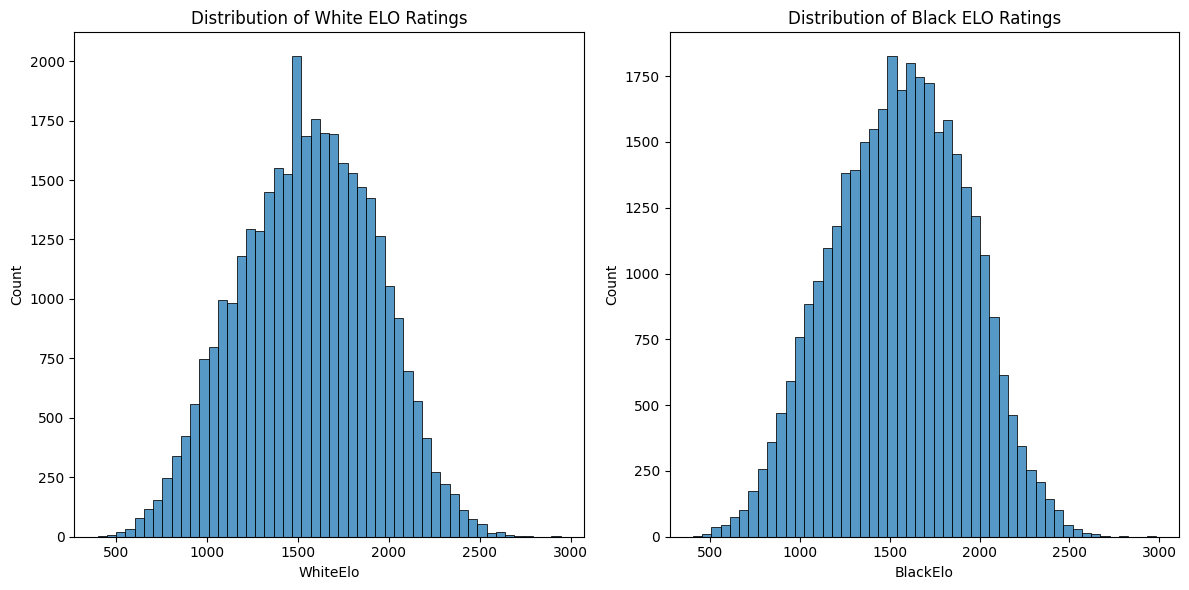

In [50]:
# Distribution of ELO ratings
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['WhiteElo'], bins=50)
plt.title('Distribution of White ELO Ratings')

plt.subplot(1, 2, 2)
sns.histplot(df_clean['BlackElo'], bins=50)
plt.title('Distribution of Black ELO Ratings')
plt.tight_layout()
plt.show()

Looking at the ELO distribution in our dataset, we see that ELO for both white and black are normally distributed, with the bulk of our chess players being in the 1400-1600 rating area. This balanced distribution will be important for our model training, as we have good representation across most skill levels.

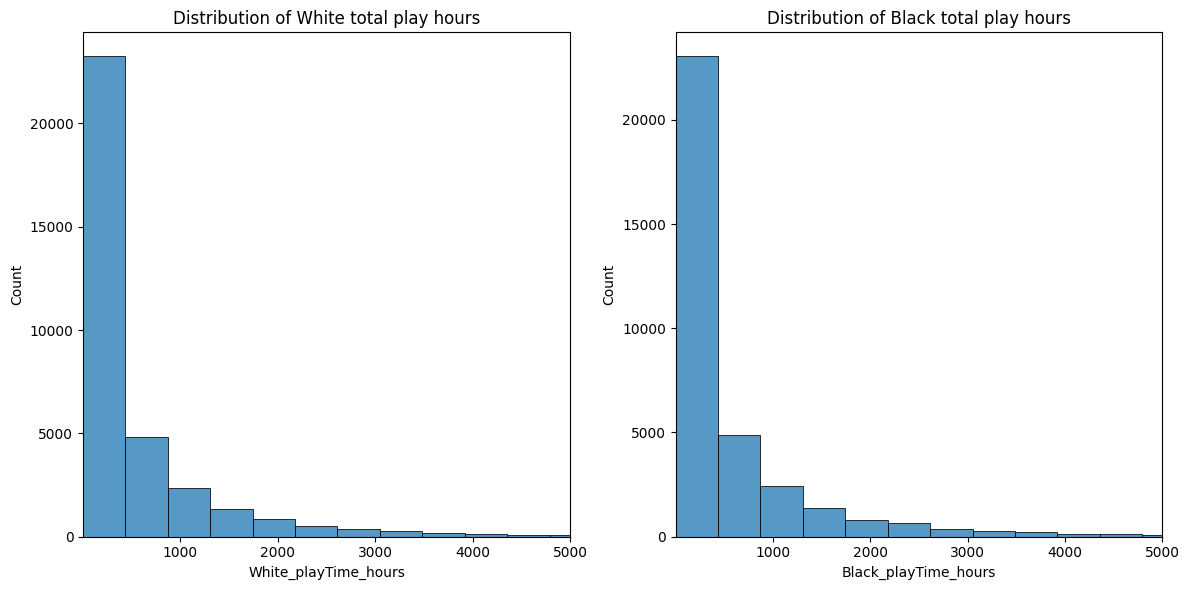

In [51]:
# Distribution of play hours
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['White_playTime_hours'], bins=50)
plt.title('Distribution of White total play hours')
plt.xlim(1, 5000)

plt.subplot(1, 2, 2)
sns.histplot(df_clean['Black_playTime_hours'], bins=50)
plt.title('Distribution of Black total play hours')
plt.xlim(1, 5000)

plt.tight_layout()
plt.show()

The histograms above show the distribution of total play hours for both white and black players. the distribution is highly right-skewed, with a long tail of players who have accumulated over 2,000 hours of play time. The majority of players fall within the 0-1,000 hour range, with a peak around 500-600 hours. The symmetry between the White and Black distributions indicates a balanced competitive environment, where players of both colors engage in comparable levels of gameplay.

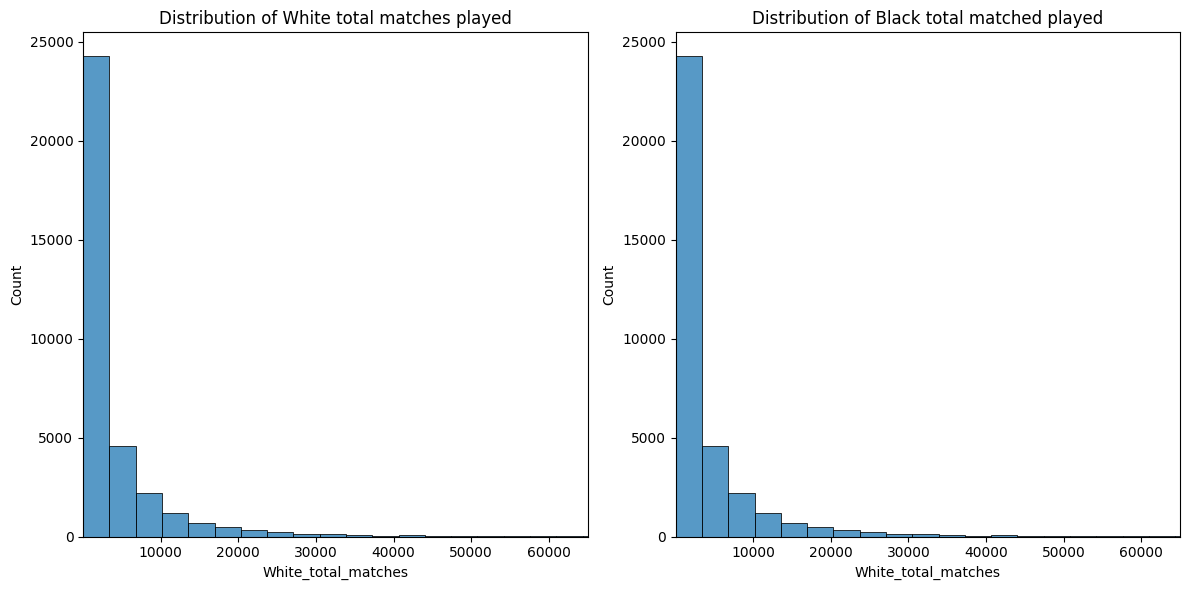

In [52]:
# Distribution of total matches played
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['White_total_matches'], bins=50)
plt.title('Distribution of White total matches played')
plt.xlim(1, 65000)

plt.subplot(1, 2, 2)
sns.histplot(df_clean['White_total_matches'], bins=50)
plt.title('Distribution of Black total matched played')
plt.xlim(1, 65000)

plt.tight_layout()
plt.show()

Analysis of the histograms of total matches played by both the white and black players shows a similar pattern to the hours played, where the vast majority of players have played between ~1-5000 matches. With a long tail of more dedicated chess players who played over 10000 games. 


### Opening Analysis

Here I perform some analysis on the Chess openings in our dataset. First I analyze what are the most and least common openings, and then I analyze for correlations between the opening of the game and the ELO of the White player. 

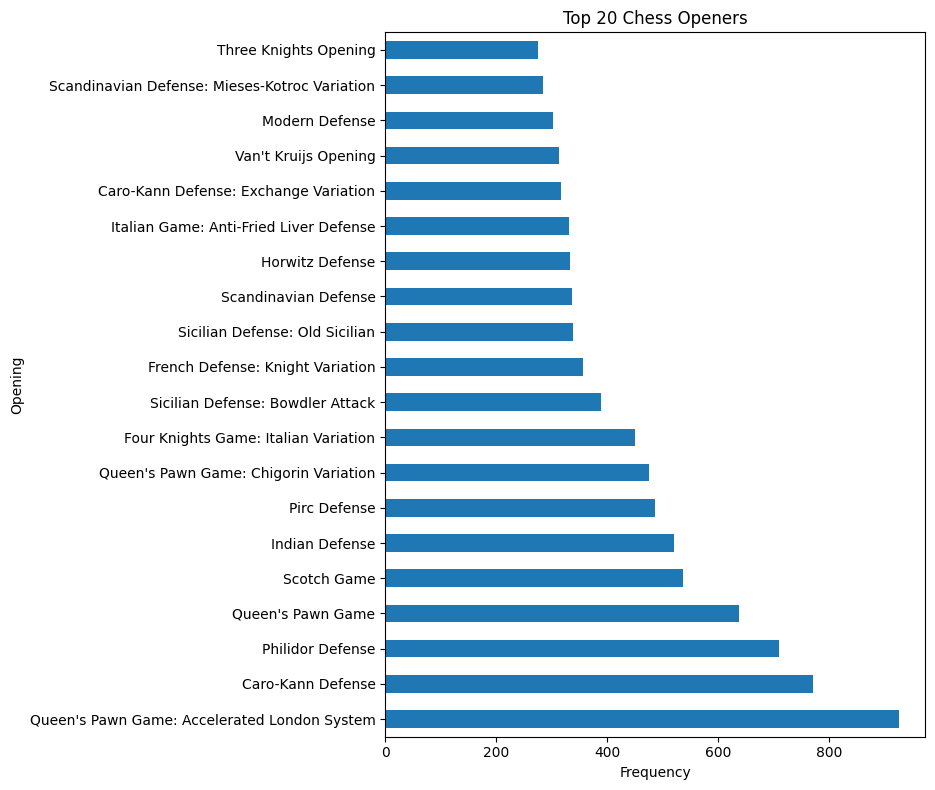

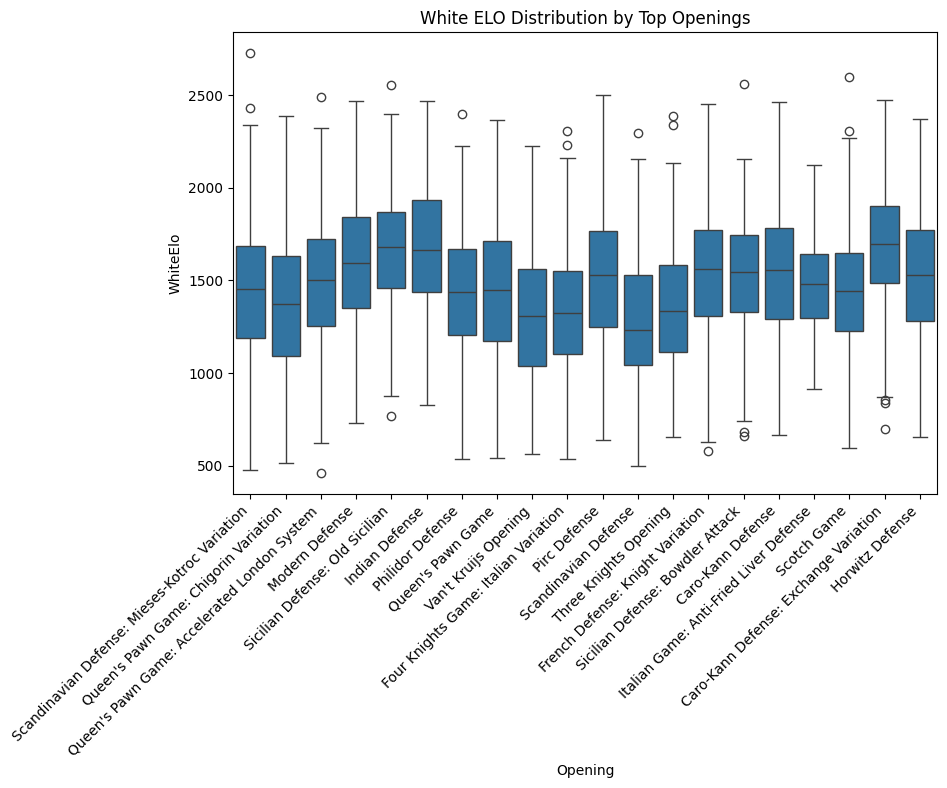

In [53]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
top_openers = df_clean['Opening'].value_counts().head(20)
top_openers.plot(kind='barh')
plt.title('Top 20 Chess Openers')
plt.xlabel('Frequency')
plt.tight_layout()

# Distribution of openers and ECO
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
top_openers = df_clean['Opening'].value_counts().head(20).index
df_filtered = df_clean[df_clean['Opening'].isin(top_openers)]
sns.boxplot(x='Opening', y='WhiteElo', data=df_filtered)
plt.title('White ELO Distribution by Top Openings')
plt.xticks(rotation=45, ha='right')

plt.show()

The most popular openings align with where most players sit in the ELO distribution (1500-1700). Which makes sense given the normal curve of our dataset. 

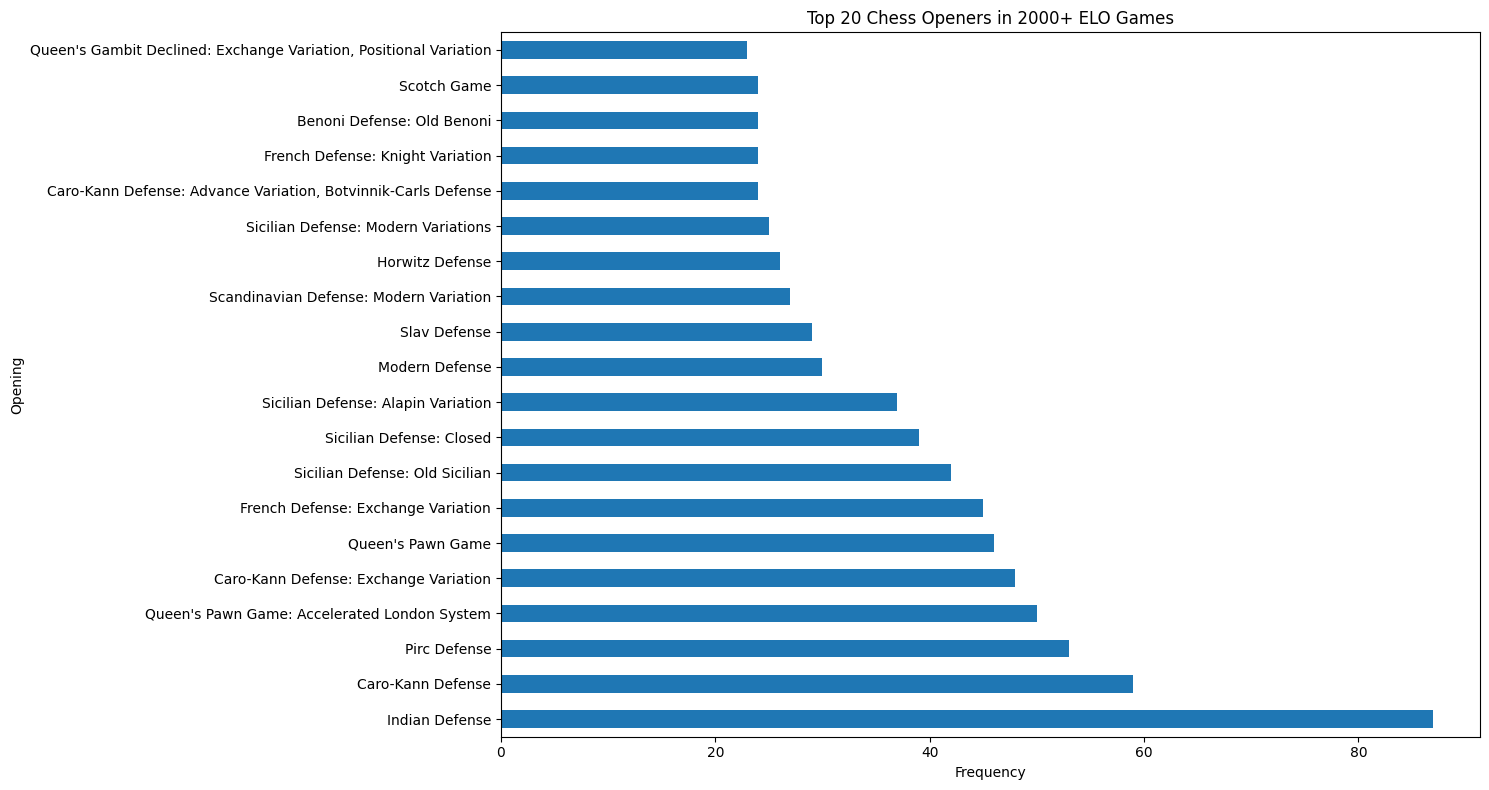

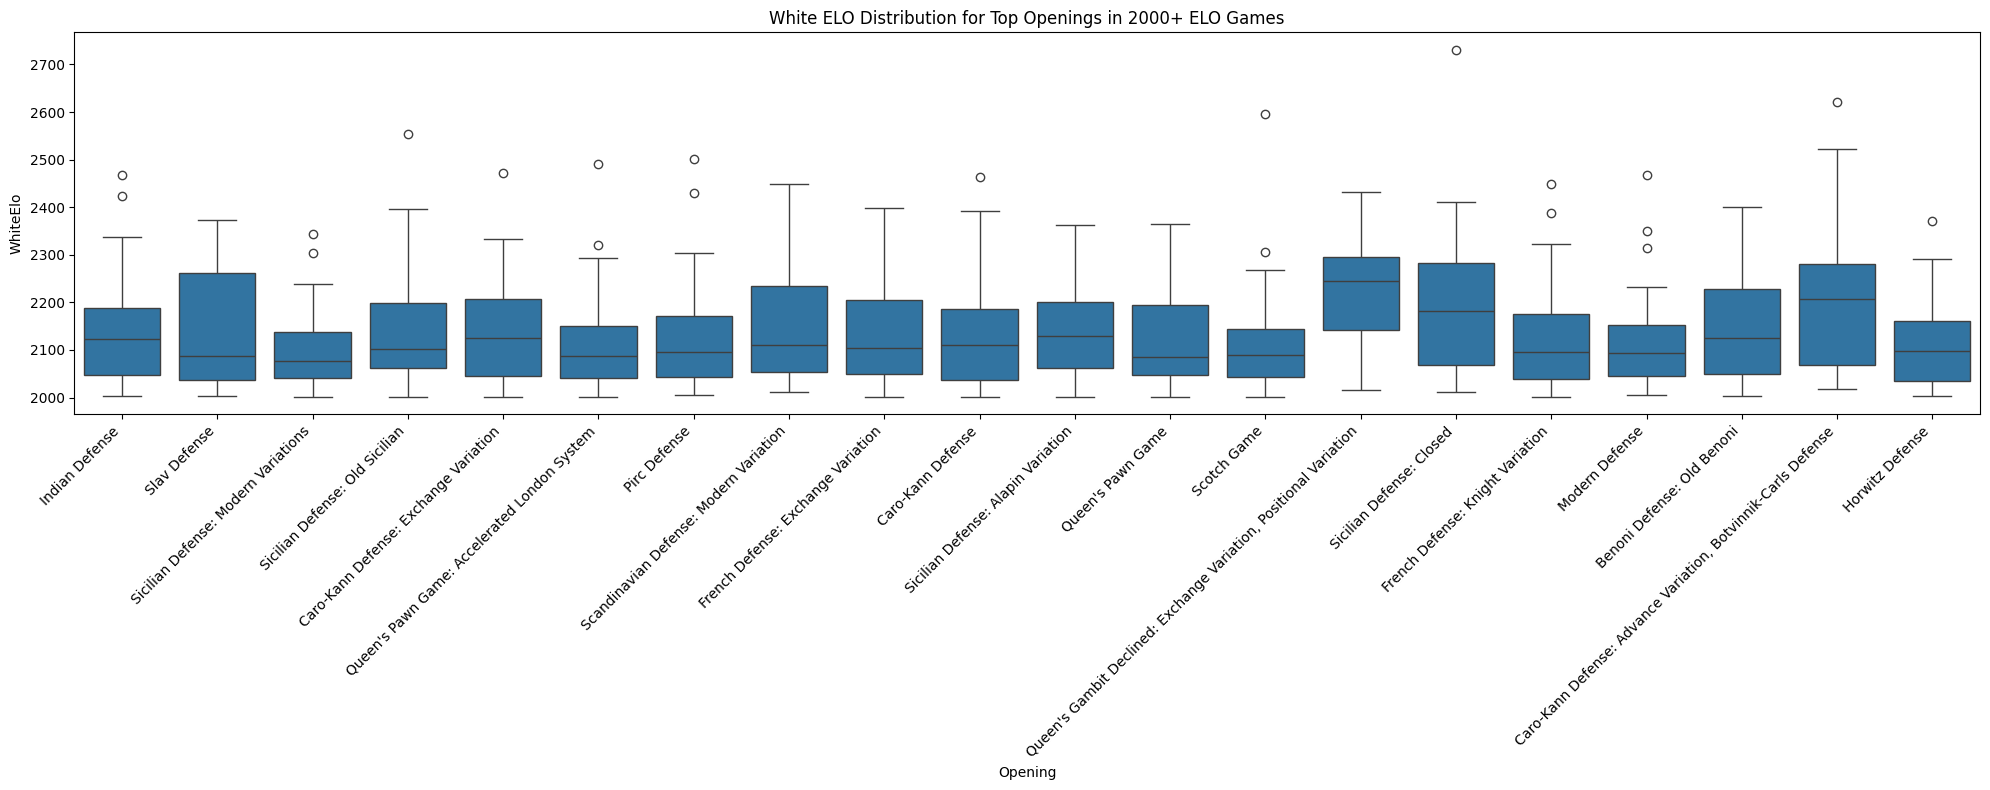

In [54]:
plt.figure(figsize=(15, 8))

# Filter for very high ELO games (2000+)
very_high_elo_games = df_clean[df_clean['WhiteElo'] >= 2000]

# Get top 20 openings in very high ELO games
top_very_high_elo_openers = very_high_elo_games['Opening'].value_counts().head(20)

# Create horizontal bar plot
top_very_high_elo_openers.plot(kind='barh')
plt.title('Top 20 Chess Openers in 2000+ ELO Games')
plt.xlabel('Frequency')
plt.tight_layout()


plt.figure(figsize=(20, 8))
# Filter for high ELO games (2000+)
high_elo_games = df_clean[df_clean['WhiteElo'] >= 2000]

# Get top 20 openings in high ELO games
top_high_elo_openers = high_elo_games['Opening'].value_counts().head(20).index

# Filter the high ELO dataset to only include those top openings
high_elo_filtered = high_elo_games[high_elo_games['Opening'].isin(top_high_elo_openers)]

# Create the boxplot
sns.boxplot(x='Opening', y='WhiteElo', data=high_elo_filtered)
plt.title('White ELO Distribution for Top Openings in 2000+ ELO Games')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

Looking at the high ELO games (2000+), we see a slightly different pattern from the total games. The Indian Defense emerges as the most frequent opening, despite having a relatively modest median ELO around 2100, while the Caro-Kann Defense remains popular even at high levels. Interestingly, the box plots show remarkably consistent median ELOs across the top openings (clustering around 2100-2200), suggesting that at this skill level, opening choice is more about strategic preference and playing style rather than any significant competitive advantage.

Basic analysis suggests that opening choice has little correlation with player rating - while popularity of certain openings varies by skill level, the consistent ELO distributions across different openings suggest skill matters more than opening selection.


### Chess Title Feature Analysis

Here I review dataset entries that have titles in them in order to observe the correlation between titles and Elo. 

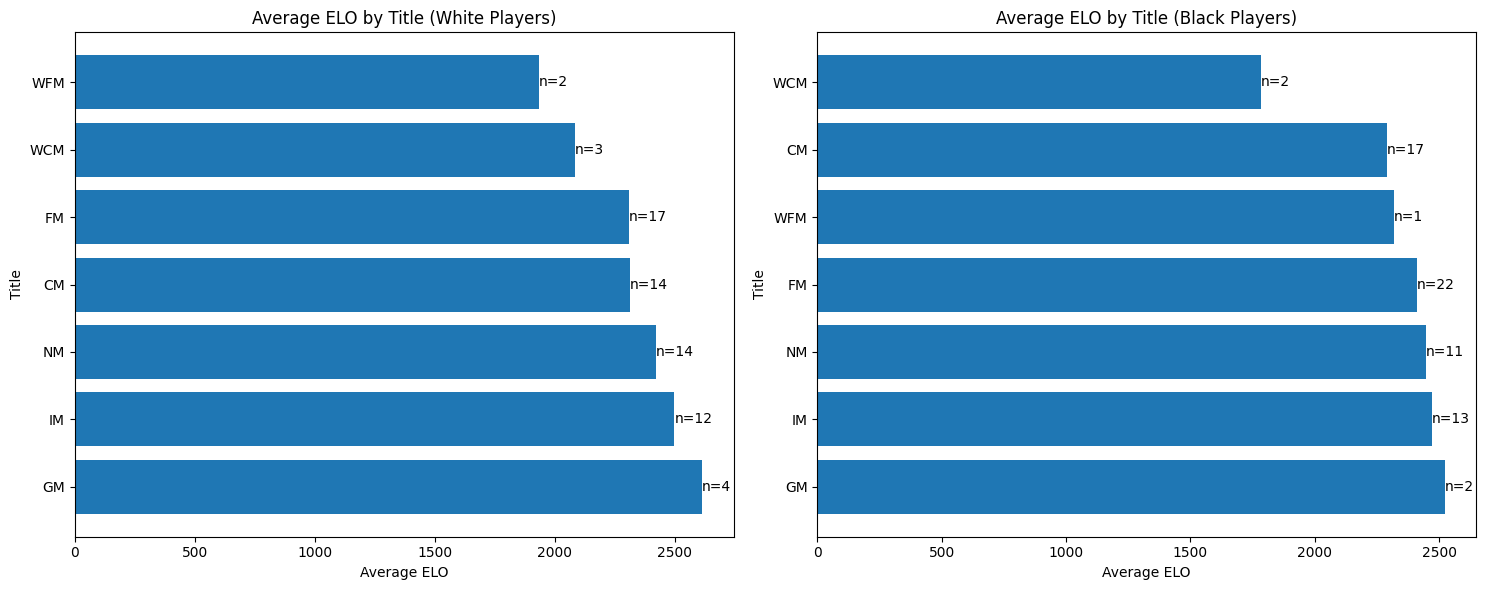


White Players Statistics:
  White_title     mean  count
2          GM  2613.25      4
3          IM  2497.67     12
4          NM  2420.14     14
0          CM  2312.14     14
1          FM  2308.18     17
5         WCM  2081.67      3
6         WFM  1932.50      2

Black Players Statistics:
  Black_title     mean  count
2          GM  2522.00      2
3          IM  2470.92     13
4          NM  2446.18     11
1          FM  2410.27     22
6         WFM  2319.00      1
0          CM  2288.76     17
5         WCM  1783.50      2


In [55]:
# Calculate average ELO for each title for White players
white_elo_by_title = df_clean.groupby('White_title')['WhiteElo'].agg(['mean', 'count']).reset_index()
white_elo_by_title = white_elo_by_title.sort_values('mean', ascending=False)  # Changed to False

# Calculate average ELO for each title for Black players
black_elo_by_title = df_clean.groupby('Black_title')['BlackElo'].agg(['mean', 'count']).reset_index()
black_elo_by_title = black_elo_by_title.sort_values('mean', ascending=False)  # Changed to False

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 6))

# Plot for White players
plt.subplot(1, 2, 1)
bars = plt.barh(white_elo_by_title['White_title'], white_elo_by_title['mean'])
plt.title('Average ELO by Title (White Players)')
plt.xlabel('Average ELO')
plt.ylabel('Title')

# Add count annotations to the bars
for i, bar in enumerate(bars):
    count = int(white_elo_by_title.iloc[i]['count'])
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'n={count}', va='center')

# Plot for Black players
plt.subplot(1, 2, 2)
bars = plt.barh(black_elo_by_title['Black_title'], black_elo_by_title['mean'])
plt.title('Average ELO by Title (Black Players)')
plt.xlabel('Average ELO')
plt.ylabel('Title')

# Add count annotations to the bars
for i, bar in enumerate(bars):
    count = int(black_elo_by_title.iloc[i]['count'])
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'n={count}', va='center')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nWhite Players Statistics:")
print(white_elo_by_title.round(2))
print("\nBlack Players Statistics:")
print(black_elo_by_title.round(2))

The data shows a clear hierarchy in chess titles, with GMs having the highest average ELO (2613 for White, 2522 for Black), followed by IMs and NMs. 

### Feature Engineering on Moves column

The moves column is currently stored in PGN (Portable Game Notation), it includes annotations for engine evaluation of position advantage (%eval - where a positive % indicates white player advantage and negative indicates black player advantage) as well as remanining clock time per move (%clk). As it stands, this column cannot be used as is for meaninful prediction and thus we will have to do some feature engineering to get what we need. My approach towards this involves parsing out average advantage for each game, as well as the number of good/brilliant moves as well as mistakes/blunders. These are annotated in the PGN notation via the '?' and '!' marks.


In [56]:
print("Example Moves Column:")
for moves in df_clean['Moves'][:1]:
    print(moves)

df_clean.head(1)

Example Moves Column:
1. Nf3 { [%eval 0.2] [%clk 0:10:00] } 1... Nf6 { [%eval 0.29] [%clk 0:10:00] } 2. d4 { [%eval 0.13] [%clk 0:09:59] } 2... g6 { [%eval 0.21] [%clk 0:09:59] } 3. c4 { [%eval 0.3] [%clk 0:09:58] } 3... Bg7 { [%eval 0.13] [%clk 0:09:58] } 4. g3 { [%eval 0.0] [%clk 0:09:57] } 4... O-O { [%eval 0.12] [%clk 0:09:56] } 5. Bg2 { [%eval 0.1] [%clk 0:09:56] } 5... d5 { [%eval 0.36] [%clk 0:09:55] } 6. O-O { [%eval 0.11] [%clk 0:09:55] } 6... c6 { [%eval 0.04] [%clk 0:09:54] } 7. Ne5 { [%eval 0.0] [%clk 0:09:53] } 7... Ng4 { [%eval 0.19] [%clk 0:09:45] } 8. cxd5 { [%eval 0.16] [%clk 0:09:31] } 8... cxd5 { [%eval 0.12] [%clk 0:09:43] } 9. Nxg4 { [%eval 0.1] [%clk 0:09:25] } 9... Bxg4 { [%eval 0.02] [%clk 0:09:41] } 10. h3 { [%eval -0.07] [%clk 0:09:22] } 10... Bf5 { [%eval 0.23] [%clk 0:09:24] } 11. Qb3 { [%eval -0.1] [%clk 0:09:12] } 11... Bxd4?! { [%eval 0.58] [%clk 0:08:28] } 12. Bh6?! { [%eval 0.02] [%clk 0:08:51] } 12... Bg7?! { [%eval 0.65] [%clk 0:08:25] } 13. Bxg7?! { 

,WhiteElo,White_createdAt,White_playTime_hours,White_total_matches,White_title,White_title_value,BlackElo,Black_createdAt,Black_playTime_hours,Black_total_matches,Black_title_value,Black_title,Moves,TotalMoves,ECO,Opening,Termination,Result
0,2289,2023-09-09,321,2352,NaN,0,2307,2023-07-02,332,1772,0,NaN,1. Nf3 { [%eval 0.2] [%clk 0:10:00] } 1... Nf6...,128,D78,"Neo-Grünfeld Defense: Classical Variation, Ori...",Normal,0-1


In [ ]:
def parse_moves(dataframe):
    """
    Parse chess moves from a dataframe column and extract statistics by color.
    
    Parameters:
    dataframe (pandas.DataFrame): Input dataframe
    
    Returns:
    DataFrame with four new columns:
        - White_avgEval: Average evaluation after white moves
        - Black_avgEval: Average evaluation after black moves
        - White_avgMoveTime: Average time spent per move by white
        - Black_avgMoveTime: Average time spent per move by black
    """

    #Method to parse each move string per row
    def parse_game_moves(moves_str):

        moves = re.findall(r'(?:\d+\.{1,3}\s*)?([A-Za-z0-9#+=\-O]+\??!?!?\??)\s*{\s*(\[%eval[^]]+\])?\s*(\[%clk[^]]+\])?\s*}', moves_str)
        white_moves = moves[::2]
        black_moves = moves[1::2]
        
        # Helper function to extract evaluation value
        def extract_eval(eval_str):
            if not eval_str:
                return 0.0

            # Regular evaluation
            match = re.search(r'%eval\s*([-+]?\d*\.?\d*)', eval_str)
            # Only convert if we have a number
            if match and match.group(1):
                try:
                    return float(match.group(1))
                except ValueError:
                    return 0.0  # Return 0.0 for any parsing errors
            return 0.0  # Return 0.0 if no match found
        
        # Helper function to extract remaining clock time in seconds
        def extract_time(clock_str):
            if not clock_str:
                return None
            # Extract time from [%clk H:MM:SS] format
            match = re.search(r'%clk\s*(\d+):(\d+):(\d+)', clock_str)
            if match:
                hours, minutes, seconds = map(int, match.groups())
                return hours * 3600 + minutes * 60 + seconds
            return None
        
        def calculate_time_per_turn(times):
            if not times or len(times) < 2:
                return times

            # Calculate the time for the first move (assuming starting time was the previous player's clock)
            first_move_time = 0

            # Calculate times for subsequent moves
            subsequent_times = [times[i] - times[i+1] for i in range(len(times)-1) if times[i] is not None and times[i+1] is not None]

            return [first_move_time] + subsequent_times
        
        #Function to tally annotations https://en.wikipedia.org/wiki/Chess_annotation_symbols
        def tally_annotations(moves):
            brilliant_moves = 0
            good_moves = 0
            blunders = 0
            mistakes = 0

            def evaluate_annotation(annotation):
                if '!!' in annotation:
                    return 'brilliant'
                elif '!' in annotation and '?' not in annotation:
                    return 'good'
                elif '??' in annotation:
                    return 'blunder'
                elif '?' in annotation and '!' not in annotation:
                    return 'mistake'
                
            for move in moves:
                move_data = move[0]
                annotation = move_data[-2:]
                evaluation = evaluate_annotation(annotation)

                if evaluation == 'brilliant':
                    brilliant_moves += 1
                elif evaluation == 'good':
                    good_moves += 1
                elif evaluation == 'blunder':
                    blunders += 1
                elif evaluation == 'mistake':
                    mistakes += 1

            return brilliant_moves, good_moves, blunders, mistakes

        # Calculate statistics
        white_evals = [extract_eval(move[1]) for move in white_moves]
        black_evals = [-extract_eval(move[1]) for move in black_moves]
        white_times = [extract_time(move[2]) for move in white_moves]
        black_times = [extract_time(move[2]) for move in black_moves]

        #Tally annotations
        white_tally = tally_annotations(white_moves)
        white_brilliant_moves = white_tally[0]
        white_good_moves = white_tally[1]
        white_blunders = white_tally[2]
        white_mistakes = white_tally[3]

        black_tally = tally_annotations(black_moves)
        black_brilliant_moves = black_tally[0]
        black_good_moves = black_tally[1]
        black_blunders = black_tally[2]
        black_mistakes = black_tally[3]

        # Calculate time taken per turn in seconds
        white_seconds_per_turn = calculate_time_per_turn(white_times)
        black_seconds_per_turn = calculate_time_per_turn(black_times)
        
        # Calculate averages, filtering out None values
        white_avg_eval = sum(filter(None, white_evals)) / len(list(filter(None, white_evals))) if any(white_evals) else None
        black_avg_eval = sum(filter(None, black_evals)) / len(list(filter(None, black_evals))) if any(black_evals) else None
        white_avg_time = sum(filter(None, white_seconds_per_turn)) / len(list(filter(None, white_seconds_per_turn))) if any(white_seconds_per_turn) else None
        black_avg_time = sum(filter(None, black_seconds_per_turn)) / len(list(filter(None, black_seconds_per_turn))) if any(black_seconds_per_turn) else None
        
        return {
            'White_avgEval': white_avg_eval,
            'Black_avgEval': black_avg_eval,
            'White_avgMoveTime': white_avg_time,
            'Black_avgMoveTime': black_avg_time,
            'White_brilliantMoves' : white_brilliant_moves,
            'Black_brilliantMoves' : black_brilliant_moves,
            'White_goodMoves' : white_good_moves,
            'Black_goodMoves' : black_good_moves,
            'White_blunders' : white_blunders,
            'Black_blunders' : black_blunders,
            'White_mistakes' : white_mistakes,
            'Black_mistakes' : black_mistakes
        }
    
    # Apply the parsing function to each row
    results = []
    for _, row in dataframe.iterrows():
        try:
            results.append(parse_game_moves(row['Moves']))
        except Exception as e:
            print(f"Error processing row: {e}")
            results.append({
                'White_avgEval': None,
                'Black_avgEval': None,
                'White_avgMoveTime': None,
                'Black_avgMoveTime': None,
                'White_brilliantMoves' : None,
                'Black_brilliantMoves' : None,
                'White_goodMoves' : None,
                'Black_goodMoves' : None,
                'White_blunders' : None,
                'Black_blunders' : None,
                'White_mistakes' : None,
                'Black_mistakes' : None
            })
    
    # Convert results to DataFrame and join with original
    results_df = pd.DataFrame(results)
    return pd.concat([dataframe, results_df], axis=1, join='inner')

    
df_enriched = df_clean.copy()
df_enriched = parse_moves(df_enriched)
df_enriched.head()

,WhiteElo,White_createdAt,White_playTime_hours,White_total_matches,White_title,White_title_value,BlackElo,Black_createdAt,Black_playTime_hours,Black_total_matches,...,White_avgMoveTime,Black_avgMoveTime,White_brilliantMoves,Black_brilliantMoves,White_goodMoves,Black_goodMoves,White_blunders,Black_blunders,White_mistakes,Black_mistakes
0,2289.0,2023-09-09,321.0,2352.0,NaN,0.0,2307.0,2023-07-02,332.0,1772.0,...,6.949153,9.344262,0.0,0.0,0.0,0.0,19.0,19.0,6.0,7.0
1,1205.0,2021-08-06,246.0,1684.0,NaN,0.0,1214.0,2023-01-15,92.0,576.0,...,3.875000,6.785714,0.0,0.0,0.0,0.0,18.0,18.0,6.0,5.0
2,1072.0,2022-09-14,544.0,2314.0,NaN,0.0,1131.0,2023-12-02,49.0,291.0,...,7.000000,7.428571,0.0,0.0,0.0,0.0,9.0,9.0,8.0,8.0
3,1661.0,2023-04-08,145.0,1015.0,NaN,0.0,1638.0,2020-12-27,105.0,797.0,...,5.761905,5.059524,0.0,0.0,0.0,0.0,25.0,23.0,9.0,12.0
4,1660.0,2018-11-28,2048.0,13436.0,NaN,0.0,1675.0,2021-03-30,590.0,8260.0,...,14.609756,9.027027,0.0,0.0,0.0,0.0,8.0,8.0,25.0,24.0


Average blunders by rating range:

White players:
WhiteElo
1000-1200    7.58
1200-1400    8.11
1400-1600    7.86
1600-1800    7.93
1800-2000    7.79
2000-2200    7.89
2200-2400    8.17
2400-2600    7.35
2600-2800    8.29
Name: White_blunders, dtype: float64

Black players:
BlackElo
1000-1200    7.80
1200-1400    8.04
1400-1600    7.88
1600-1800    7.85
1800-2000    7.78
2000-2200    8.03
2200-2400    7.83
2400-2600    8.73
2600-2800    6.38
Name: Black_blunders, dtype: float64


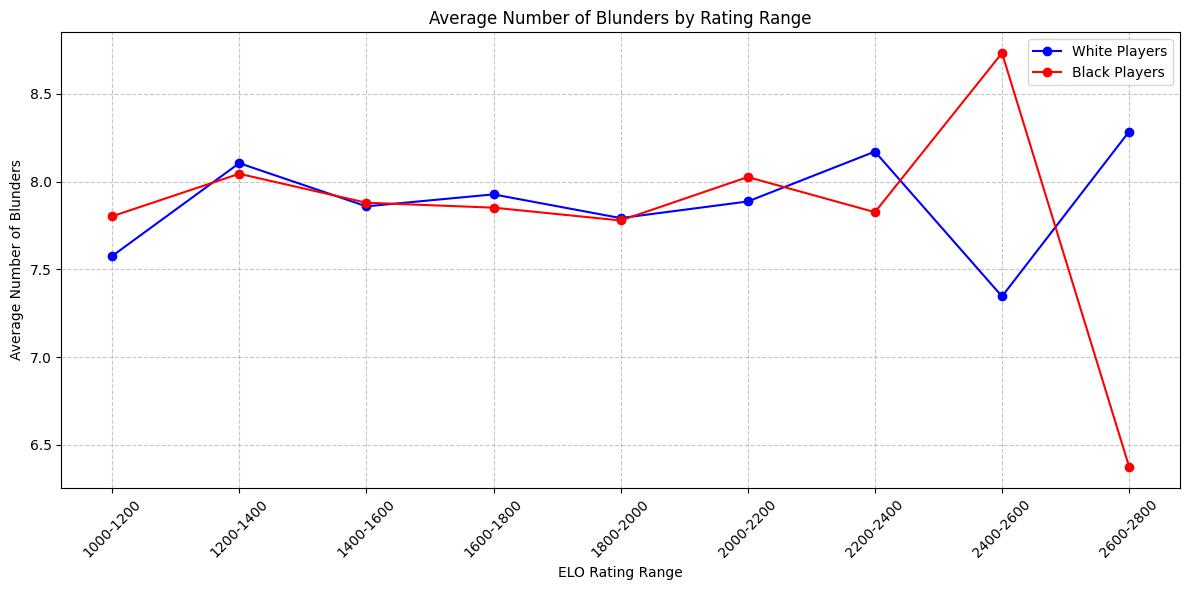

In [58]:
# Create rating ranges (bins)
bins = list(range(1000, 3000, 200))  # Creates ranges like 1000-1200, 1200-1400, etc.
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Calculate average blunders for each rating range
white_binned = pd.cut(df_enriched['WhiteElo'], bins=bins, labels=labels)
black_binned = pd.cut(df_enriched['BlackElo'], bins=bins, labels=labels)

# Add observed=True to address the warning
white_blunders = df_enriched.groupby(white_binned, observed=True)['White_blunders'].mean()
black_blunders = df_enriched.groupby(black_binned, observed=True)['Black_blunders'].mean()

# Create the visualization
plt.figure(figsize=(12, 6))

# Plot bars for both White and Black players
plt.plot(range(len(labels)), white_blunders, marker='o', color='blue', label='White Players')
plt.plot(range(len(labels)), black_blunders, marker='o', color='red', label='Black Players')

# Customize the plot
plt.title('Average Number of Blunders by Rating Range')
plt.xlabel('ELO Rating Range')
plt.ylabel('Average Number of Blunders')
plt.xticks(range(len(labels)), labels, rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Print some statistics
print("Average blunders by rating range:")
print("\nWhite players:")
print(white_blunders.round(2))
print("\nBlack players:")
print(black_blunders.round(2))

plt.tight_layout()
plt.show()

Average mistakes by rating range:

White players:
WhiteElo
1000-1200    12.51
1200-1400    12.39
1400-1600    12.16
1600-1800    12.43
1800-2000    12.57
2000-2200    12.31
2200-2400    12.09
2400-2600    11.61
2600-2800     9.24
Name: White_mistakes, dtype: float64

Black players:
BlackElo
1000-1200    12.61
1200-1400    12.43
1400-1600    12.17
1600-1800    12.43
1800-2000    12.60
2000-2200    12.52
2200-2400    11.90
2400-2600    12.18
2600-2800    11.31
Name: Black_mistakes, dtype: float64


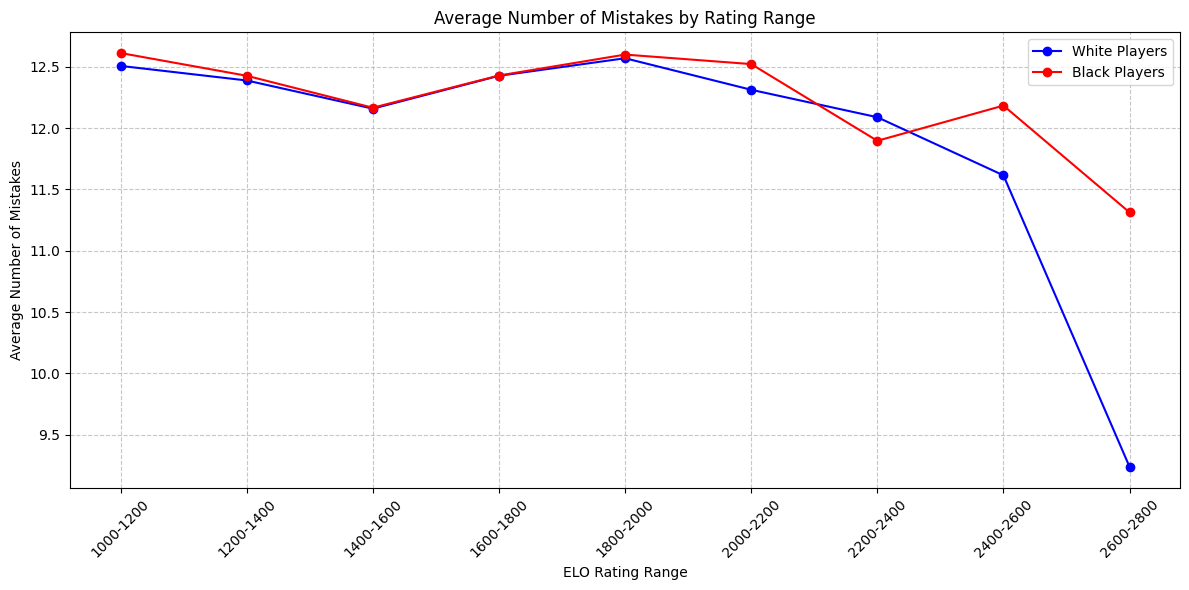

In [59]:
# Create rating ranges (bins)
bins = list(range(1000, 3000, 200))  # Creates ranges like 1000-1200, 1200-1400, etc.
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Calculate average mistakes for each rating range
white_binned = pd.cut(df_enriched['WhiteElo'], bins=bins, labels=labels)
black_binned = pd.cut(df_enriched['BlackElo'], bins=bins, labels=labels)

# Add observed=True to address the warning
white_mistakes = df_enriched.groupby(white_binned, observed=True)['White_mistakes'].mean()
black_mistakes = df_enriched.groupby(black_binned, observed=True)['Black_mistakes'].mean()

# Create the visualization
plt.figure(figsize=(12, 6))

# Plot lines for both White and Black players
plt.plot(range(len(labels)), white_mistakes, marker='o', color='blue', label='White Players')
plt.plot(range(len(labels)), black_mistakes, marker='o', color='red', label='Black Players')

# Customize the plot
plt.title('Average Number of Mistakes by Rating Range')
plt.xlabel('ELO Rating Range')
plt.ylabel('Average Number of Mistakes')
plt.xticks(range(len(labels)), labels, rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Print some statistics
print("Average mistakes by rating range:")
print("\nWhite players:")
print(white_mistakes.round(2))
print("\nBlack players:")
print(black_mistakes.round(2))

plt.tight_layout()
plt.show()

The statistics and charts above show that we may be able to derive some value from the number of blunders/mistakes for ELO prediction. However the relationship is not as strong as I would have hoped. 

However, based on the data available, I believe I have everything I need to proceed with Model training. I conduct one additional check on my dataset to make sure I have everything I need.

In [60]:
# Confirm that we do not have missing values for our critical columns by this point
critical_columns = ['WhiteElo', 'BlackElo', 
                   'White_playTime_hours', 'Black_playTime_hours', 
                   'White_total_matches', 'Black_total_matches', 
                   'White_title_value', 'Black_title_value',
                   'Moves', 'White_avgEval', 'Black_avgEval', 'White_blunders', 'Black_blunders', 'White_mistakes', 'Black_mistakes', 'White_avgMoveTime', 'Black_avgMoveTime', 'TotalMoves', 'ECO', 'Opening']

# Check for missing values in critical columns only
missing_values = df_enriched[critical_columns].isnull().sum()
print("Missing values in critical columns in df_enriched:")
for col, count in missing_values.items():
    print(f"{col}: {count}")

# Additional verification
print("\nDataset shape:", df_enriched.shape)

Missing values in critical columns in df_enriched:
WhiteElo: 2904
BlackElo: 2904
White_playTime_hours: 2904
Black_playTime_hours: 2904
White_total_matches: 2904
Black_total_matches: 2904
White_title_value: 2904
Black_title_value: 2904
Moves: 2904
White_avgEval: 2904
Black_avgEval: 2904
White_blunders: 2904
Black_blunders: 2904
White_mistakes: 2904
Black_mistakes: 2904
White_avgMoveTime: 2904
Black_avgMoveTime: 2904
TotalMoves: 2904
ECO: 2904
Opening: 2904

Dataset shape: (37427, 30)


## Model Training